# High $p_T$ tracks

**Motivation:** In the `Extended-Hybrid` notebook, to motivate the retraining, I was looking into how the # of HF tracks evolved as a funciton of jet $p_T$.

<img src="../../figures/mc16d_PFlow_Zprime_5TeV/nTrks_HF_frag.pdf" width="400">

However, Michael was concerned that we the average # of b-hadron tracks is *less than 1* at high $p_T$. I wasn't sure at this stage if this was a function of the 
1. Track efficiency crapping out at high $p_T$ (as is motivated by the trackless b-tagging teams)
2. An artifact of the way that I'm doing the track selection by sorting by $s_{d0}$ and then selecting the leading 15 tracks. Since QCD is fractal, we have more tracks at high $p_T$, so this could be an artifact of my pre-processing instead of the physics.


In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("../..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


**Plan to disentangle this:**
- Look at the number of tracks for each of the jet flavors in a *single* extended Z' sample
- Maybe I could also plot the $s_{d0}$ and $d_0$ in the $Z$ sample

In [2]:
# open the df

nTrks = 25
dataDir = '../../data/mc16d_PFlow_Zprime_5TeV/files_{}trks_sd0_rev/'.format(nTrks)
df_tag = '10ktest_{}trks_sd0_rev_000001'.format(nTrks)

jet_df = pd.read_hdf('{}/jet_{}.h5'.format(dataDir,df_tag), key='jet_df')
trk_xr = xr.open_dataarray('{}/trk_{}.nc'.format(dataDir,df_tag))

In [3]:
jet_df.ip3d_ntrk.max()

70.0

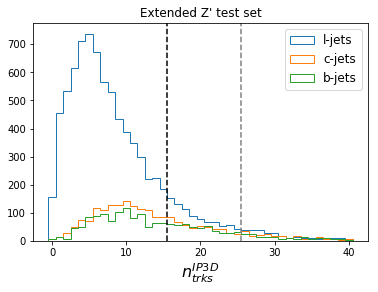

In [4]:
figDir = '../../figures'
myRange = (-0.5,40.5)
nBins=41

for pdg, flav in zip([0,4,5],['l','c','b']):

    plt.hist(jet_df.loc[jet_df.LabDr_HadF==pdg,'ip3d_ntrk'],
             label=flav+'-jets',histtype='step',
             bins=nBins,range=myRange)

ylim = plt.ylim()
plt.plot([15.5,15.5],ylim,'k--')
plt.plot([25.5,25.5],ylim,'gray',linestyle='--')
plt.ylim(ylim)

plt.legend(fontsize=12)
plt.xlabel('$n_{trks}^{IP3D}$',fontsize=16)
plt.title('Extended Z\' test set')
plt.savefig('{}/mc16d_PFlow_Zprime_5TeV/nTrks_ip3d.pdf'.format(figDir))
plt.show()

**Conclusion:**
If I cut on 15, I'm definitely not getting all of the desired ip3d tracks.
I think I should reprocess the data, cutting at like 30 or 40 tracks.

In [5]:
# Load in the model that has been trained on 15 tracks

nFeatures = 13
nHidden = 400

vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
modelDir = "../../models/mc16d_PFlow_hybrid_5TeV"
dataTagTrain = "5mtrain_15trks_{}_sd0_rev".format(vStr)
m1 = myLSTM(modelDir=modelDir, nFeatures=nFeatures, nHidden=nHidden, dataTag=dataTagTrain, loadModel=True)


Initialize method from myModel()
Loading previously trained LSTM


In [6]:
m2 = myLSTM(modelDir=modelDir, nFeatures=nFeatures, nHidden=nHidden, 
            dataTag=dataTagTrain, timeSteps=25, loadModel=False)

for layer in ['LSTM','dense_1','Jet_class']:
    w = m1.model.get_layer(layer).get_weights()
    m2.model.get_layer(layer).set_weights(w)

Initialize method from myModel()
Building the baseline LSTM


In [7]:
dataTagTrain = "5mtrain_25trks_{}_sd0_rev".format(vStr)
m3 = myLSTM(modelDir=modelDir, nFeatures=nFeatures, nHidden=nHidden, 
            dataTag=dataTagTrain, timeSteps=25, loadModel=True)

Initialize method from myModel()
Building the baseline LSTM


Looking at 15 tracks
  Getting key for HF tracks
  Getting key for frag tracks
  Getting the HF and frag tracks
  Evaluating on the model
Load in the previously saved efficiency file
Looking at 25 tracks
  Getting key for HF tracks
  Getting key for frag tracks
  Getting the HF and frag tracks
  Evaluating on the model
Load in the previously saved efficiency file
Looking at 25 tracks
  Getting key for HF tracks
  Getting key for frag tracks
  Getting the HF and frag tracks
  Evaluating on the model
min: -0.57, max: 0.37


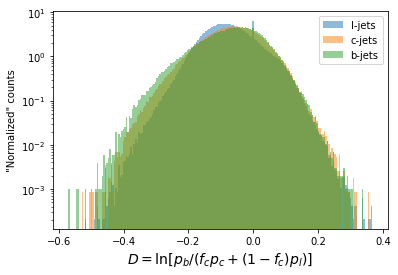

In [8]:
mid_pts, mu_HFs, mu_frags = [], [], []
subDir = 'mc16d_PFlow_Zprime_5TeV'
dataDir = '../../data/'+subDir

leffs, ceffs, beffs, = [],[],[]
discs, labels = [],[]
ys, pts, etas = [],[],[]

i = 0

for nTrks,scale_tag,tag,m in zip([15,25,25],
                                 ["_hybrid_5TeV_scale","_hybrid_5TeV_scale_15trks","_hybrid_5TeV_scale"],
                                 ['_eval_Zprime_5TeV','_eval_Zprime_5TeV_25trks','_eval_Zprime_5TeV'],
                                 [m1,m2,m3]): 
    
    print('Looking at {} tracks'.format(nTrks))
    
    # Get the processed input data
    dataTagTest = "2mtest_{}trks_{}_sd0_rev{}".format(nTrks,vStr,scale_tag)

    f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)

    f = h5py.File(f_name,"r")

    X = f['X_test'][:]
    y = f['y_test'][:]
    ix = f['ix_test'][:]

    f.close()
    
    # Get the track origin and the jet pT
    dataDir = '../../data/mc16d_PFlow_Zprime_5TeV/'.format(nTrks)
    df_tag = '2mtest_{}trks_sd0_rev'.format(nTrks)

    jet_df = pd.read_hdf('{}/jet_{}.h5'.format(dataDir,df_tag), key='jet_df')
    trk_xr = xr.open_dataarray('{}/trk_{}.nc'.format(dataDir,df_tag))

    # Add the HF and frag cols to the dfs
    trk_origs = trk_xr.loc[:,:,'orig'].values
    for o, orig_tag in zip([(0,1), 2], ['HF','frag']):

        print("  Getting key for {} tracks".format(orig_tag))
        
        if type(o) == tuple:
            orig_mask = np.zeros(nTrks, dtype=np.bool)
            for oi in o:
                orig_mask = orig_mask | (trk_origs == oi)

            # For this jet, I can't just *add* up the origin mask, b/c the b-jets have 
            # this variable assigned as the mask values
            trkExists = (np.sum(X, axis=-1) != 0)

            orig_mask = orig_mask & trkExists

        else:
            orig_mask = (trk_origs == o)

        key = 'ntrk_' + orig_tag
        jet_df[key] = np.sum(orig_mask, axis=-1)
    
    print("  Getting the HF and frag tracks") 
    
    # Histogramize the jet pT
    start, step = 0, 10 # GeV
    stop = np.max(jet_df.pt)

    pT_edges = np.arange(start, stop+step, step)

    indices = np.digitize(jet_df['pt'], pT_edges)
    
    mid_pt = (pT_edges[1:]+pT_edges[:-1]) / 2

    mu_HF = np.array([jet_df.loc[(indices==i)&(jet_df['LabDr_HadF']==5),'ntrk_HF'].mean() for i in range(1,pT_edges.shape[0])])
    mu_frag = np.array([jet_df.loc[(indices==i)&(jet_df['LabDr_HadF']==5),'ntrk_frag'].mean() for i in range(1,pT_edges.shape[0])])
 
    mid_pts.append(mid_pt)
    mu_HFs.append(mu_HF)
    mu_frags.append(mu_frag)

    print("  Evaluating on the model") 
    
    # Evaluate the model for this track selection
    if i == 2:
        (leff, ceff, beff), d = sigBkgEff(m, X, y, ix, returnDisc=True,
                                          figDir=figDir,subDir=subDir,modelDir=modelDir,tag=tag)
    else:
        (leff, ceff, beff), d = getEffs(m, X, y, ix, returnDisc=True,
                                        figDir=figDir,subDir=subDir,modelDir=modelDir,tag=tag)
    
    leffs.append(leff)
    ceffs.append(ceff)
    beffs.append(beff)

    discs.append(d)
    
    ys.append(y)
    pts.append(jet_df.pt.values)
    etas.append(jet_df.eta.values)
    
    i += 1

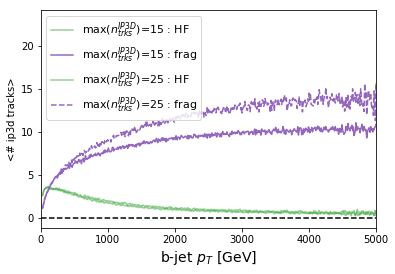

In [9]:
for nTrks, mid_pt, mu_HF, mu_frag, l in zip([15,25], mid_pts, mu_HFs, mu_frags,['-','--']):
    label = 'max($n_{trks}^{IP3D}$)='+str(nTrks)
    plt.plot(mid_pt,mu_HF,label=label+' : HF',color='C2',alpha=0.5)
    plt.plot(mid_pt,mu_frag,label=label+' : frag',color='C4',linestyle=l)

plt.plot([0,5000],[0,0],'k--')

plt.xlim(0,5000)
plt.xlabel('b-jet $p_T$ [GeV]', fontsize = 14)
plt.ylabel('<# ip3d tracks>')
plt.legend(fontsize=11)

plt.savefig('{}/mc16d_PFlow_Zprime_5TeV/nTrks_HF_frag_cf_15_25.pdf'.format(figDir,nTrks))

plt.show()

Ok, so since this was not a big effect, I don't think spending a lot of time on retraining is going to be worth my time... *this is a huge timesaver*!

In [10]:
# # Load in the model that has been trained on 25 tracks
# dataTagTrain = "3mtrain_25trks_{}_sd0_rev".format(vStr)
# m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, nHidden=nHidden, timeSteps=25,
#            dataTag=dataTagTrain, loadModel=True)
# (leff, ceff, beff), d = getEffs(m3, X, y, ix, returnDisc=True,
#                                 figDir=figDir,subDir=subDir,modelDir=modelDir,tag=tag)
    
# leffs.append(leff)
# ceffs.append(ceff)
# beffs.append(beff)

# discs.append(d)
# #labels.append('train {}, eval {}'.format(trainPhysicsSample,physicsSample))

# ys.append(y)
# pts.append(jet_df.pt.values)
# etas.append(jet_df.eta.values)

In [11]:
plotROC(beffs, leffs, labels, ymax=100, #rrange=(0.9,1.2),
             text=text,ylabel='l-rej',#binomialErrors=True,nTest=Ntest, 
             colors=colors)#, figDir=figDir,subDir=subDir,tag='lrej_'+tag)

plotROC(beffs, ceffs, labels, ymax=10, #rrange=(0.9,1.2),
             text=text,ylabel='c-rej',#binomialErrors=True,nTest=Ntest, 
             colors=colors)#, figDir=figDir,subDir=subDir,tag='crej_'+tag)

NameError: name 'text' is not defined

In [ ]:
# Get the roc ratio plot

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"Eval on mc16d $Z'$ 5 TeV"

tag = 'cf_ext_hyb_25_trks'

labels = ['train and eval w/ max 15 trks',
          'train w/ max 15 trks, eval w/ max 25 trks',
          'train and eval w/ max 25 trks']

colors = ['C6','C0','C1']
Ntest = int(1.5e6)

plotROCRatio(beffs, leffs, labels, rrange=(0.9,1.2),ymax=100,
             text=text,ylabel='l-rej',binomialErrors=True,nTest=Ntest, 
             colors=colors)#, figDir=figDir,subDir=subDir,tag='lrej_'+tag)

plotROCRatio(beffs, ceffs, labels, rrange=(0.9,1.2),ymax=10,
             text=text,ylabel='c-rej',binomialErrors=True,nTest=Ntest, 
             colors=colors)#, figDir=figDir,subDir=subDir,tag='crej_'+tag)

In [ ]:
len(discs)

In [ ]:
# But something is wrong w/ these b/c the pts are not the same
ptmin=20
ptmax=5000
plotPtDependence(pts[1],ys[1],discs,
                 labels[:2],colors=colors[:2],
                 lrej_lim=(0,25),crej_lim=(0,4),beff_lim=(0,1),
                 flat=True,binomialErrors=True,text=text,
                 pt_edges=np.linspace(ptmin,ptmax,20),
                 eff_bins = np.linspace(ptmin,ptmax,100),
                 figDir=figDir,subDir=subDir,tag=tag,verbose=False)